In [2]:
clean_up=True # removes gams-related files in work-folder if true
%run StdPackages.ipynb
os.chdir(py['main'])
import global_settings,ReadData,ShockFunction,Production,Household,GE,Invest,Trade,Government,diagnostics
from DataBase_wheels import small_updates
os.chdir(curr)
data_folder = os.getcwd()+'\\Data\\IO'
gams_folder = os.getcwd()+'\\gamsmodels\\GE'

The file_gams_py_gdb0.gdx is still active and was not deleted.
The file_gams_py_gdb3.gdx is still active and was not deleted.


# Set up a dynamic, general equilibrium model

*The current general equilibrium model is a small open economy that features exogenous long run interest-, inflation-, and growth rates. These settings are defined in the global settings:*

In [3]:
name = 'GE'
gs_v = 'gs_v1'
tindex = range(1,4)
gs_vals = {'t':tindex}
gs = global_settings.gs_v1(kwargs_vals=gs_vals)

## **1: Setup**

The fundamental setup:
* The model consists of three fundamental sets that most equations/variables are defined over: (1) $n$ the set of goods in the economy, (2) $s$ the set of sectors, $t$ the time index.
* We distinguish between prices of various sorts $(PbT,Peq,PwT)$, quantities $(qS,qD)$, and values $(vD,vS)$. Beyond this, a number of other variables are additionally used in various modules.
* Market clearing ensures that the sum of supply equals the sum of supply, for a subset of goods $n$. As goods can be demanded/supplied by more than one sector, the market clearing condition is:
$$\begin{align}
    \sum_{s\in d\_qS[s,n]} qS[t,s,n] = \sum_{s\in d\_qD[s,n]} qD[t,s,n],
\end{align}$$
where $d\_qS$ and $d\_qD$ are dummies identifying which sectors are active for the relevant good.

## **2: Data**

The relevant data needed to run each module may vary. However, in general, the general equilibrium module should be adjusted to be consistent with input-output data. In a single year, the IO baseline data should at least cover:
* The equilibrium price for all traded goods.
* The inputs/outputs in values for each domestic sector, for each type of goods. The system must be balanced, such that the sum of demand equals the sum of supply for each $s$.

The following reads in the IO data and defines a number of default subsets:

In [4]:
dsheets = {'Production_v': data_folder+'\\IO_v.xlsx', 'Production_p': data_folder+'\\IO_p.xlsx'}
GE_data = ReadData.read_data.main(dsheets,name='GE_data',components=['domstic','trade','HH','tax','invest'])

To the IO data, we add inventory data on durables:

In [5]:
DataBase.GPM_database.merge_dbs(GE_data,excel2py.xl2PM.pm_from_workbook(data_folder+'\\'+'dur.xlsx',{k: 'vars' for k in ('prod','HH','G')}),'second')

Furthermore, we read in data on tax rates:

In [6]:
DataBase.GPM_database.merge_dbs(GE_data,excel2py.xl2PM.pm_from_workbook(data_folder+'\\'+'Tax.xlsx',{'tbaseyear': 'vars'}),'second')

Note that - while not necessary - the tax rates should be of a size such that the total tax revenue corresponds to the income from the IO data; the government module can adjust some tax rates to ensure this, however, this will be in a somwhat random fashion. To check for this assertion, the following IO function computes the tax income on sectorial level, when tax rates consists of three componenets: Input taxes $tauD$, output taxes $tauSflat$ and lump sum taxes $tauLump$:

In [7]:
pd.DataFrame({'Model': Government.taxRevenue(GE_data), 'IO': GE_data['vD'].rctree_pd(GE_data['n_tax']).droplevel(-1)})

,Model,IO
s,,
F,0.0909422,-0.018329
HH,1.80099,1.61747
I_B,0.250148,0.263686
I_M,0.207596,0.202365
a,0.442536,0.058697
b,1.60557,0.827386
itory,0.00155662,0.00228146


Some of these discrepancies can be adjusted using the lump-sum tax rate; however, not all sectors are taxed lump-sum. The following adjusts the lump sum taxes, but leaves the two sectors 'inventory' and 'foreign' sectors unbalanced:

In [8]:
GE_data['tauLump'] = Government.balanceIO_lumpsum(GE_data)
pd.DataFrame({'Model': Government.taxRevenue(GE_data), 'IO': GE_data['vD'].rctree_pd(GE_data['n_tax']).droplevel(-1)})

,Model,IO
s,,
F,0.0909422,-0.018329
HH,1.61747,1.61747
I_B,0.263686,0.263686
I_M,0.202365,0.202365
a,0.058697,0.058697
b,0.827386,0.827386
itory,0.00155662,0.00228146


To adjust the final two sectors' tax revenues, we can move the taxes on demand upward/downward by the same amount for all goods. we make this adjustment on the demand taxes ($tauD$), as the sectors that are not taxed lump-sum (itory, F) are not supplying anything in the model:

In [9]:
rates = Government.balanceIO_advalorem(GE_data)
GE_data['tauD'] = rates[~(rates==0)]

And adjust the prices with taxes, to be defined as the equilibrium price, plus taxes:

In [10]:
GE_data['PwT'].vals = GE_data.get('PwT').add(GE_data.get('tauD'),fill_value=0)

Export the database:

In [11]:
GE_data.export(repo=gams_folder)

Beyond this, we require a lot of data. This is handled along the way in the specific modules.

## **3: Model components**

In the following we go through the various modules, including (1) which data we require for the model to run, (2) how to initialize the model, (3) run and calibrate the model separately, and (4) store the calibrated version.

## **3.1: The *Production.py* module**

*The production module is handled in more detail in the notebook 'Ex1\_production.ipynb'. Here we run briefly through the model.*

The production module is build primarily on nesting trees. The trees specify how the sectors combine inputs to produce its respective outputs. A number of different type of nesting functions are available (see *gams\_production.py*). In the following, the two production sectors in our toy model simply use the relevant inputs in a nested CES manner.

### *Required Data:*

The necessary data includes:
1. IO data on the sectors (already included).
2. The nesting structure of inputs including technical parameters detailing the production structure (CES parameters).
3. An inventory of the durables owned by each sector.

In the current case, the model includes two durables for each production sector: Machines ($iM$) and buildings ($iB$). This information is read from the IO data, but can also be added manually along the way. The production module includes quite a lot of flexibility (e.g. in nesting structure and functional forms). The following illustrates an example where a lot of default values are applied: 

*Define settings for the module:*

In [12]:
name_module = 'p'
trees = {'a': {'file': 'S1.xlsx', 'sheets': ['lower_nests', 'upper_nest']}, 
         'b': {'file': 'S2.xlsx', 'sheets': ['lower_nests', 'upper_nest']}}
temp_namespace = {'a': 'a_in', 'b':'b_in'} # used when reading in nesting trees, to distinguish input and output elements with identical names.
kwargs_st = {'sector': True, 'ss': GE_data.get('s_prod')} # settings for initializing the module

*Read in data to nesting tree:*

In [13]:
nts = {}
for s,t in trees.items():
    nts[s] = nesting_tree.nesting_tree(name=name_module) # initialize tree
    for tree in t['sheets']:
        nts[s].add_tree(data_folder+'\\'+t['file'],tree_name=tree,**{'sheet':tree}) # add nesting structure
        DataBase.GPM_database.merge_dbs(nts[s].trees[tree].database, excel2py.xl2PM.pm_from_workbook(data_folder+'\\'+t['file'],{tree:'vars'}),'second') # add data
        if tree.startswith('lower'):
            nts[s].trees[tree].temp_namespace = temp_namespace
    nts[s].run_all(s0=s) # add default attributes from nesting structure
nesting_tree.merge_nts(list(nts.values())[0], list(nts.values())[1:]) # merge trees into one.
nt = list(nts.values())[0]

### *Static model:*

Start by setting up a static model from the nesting tree:

In [14]:
gm_static = Production.pr_static(nt=nt,work_folder = work_folder,**{'data_folder':work_folder,'name':'p_static'})

Add data from the general equilibrium data, but restrict it to the data on production sectors (not necessary, but neat):

In [15]:
GE_prod = small_updates.subset_db(GE_data.copy(),GE_data.get('s_prod'))

Calibrate the model (See *Ex1_production* for more on these settings):

*1: Calibrate to inputs that are exogenous in the baseline settings:*

In [16]:
gm_static.write_and_run(name='v1',add_checkpoint='v1')
db_temp = gm_static.slice_exo(GE_prod,copy=True)
gm_static.model_instances['v1'].solve_sneakily(db_star=db_temp, from_cp = True, cp_init = gm_static.checkpoints['v1'], kwargs_shock={'n_steps':10})

{'Modelstat': 16.0, 'Solvestat': 1.0}

*2: read current solution back to main database:*

In [16]:
db = gm_static.model_instances['v1'].out_db
[db.series.__delitem__(sym) for sym in db.symbols if sym not in gm_static.model.database.symbols]; # delete symbols that are created only in order to calibrate model.
gm_static.model.database.merge_dbs(gm_static.model.database,db,'second')

*3: calibrate to the other moments in the data:*

In [17]:
gm_static.reset_settings()
gm_static.setstate('DC')
db_temp = gm_static.slice_exo(GE_prod,copy=True)
gm_static.calibrate_sneaky(db_temp,**{'n_steps':100})

{'Modelstat': 16.0, 'Solvestat': 1.0}

*inspect solution compared to IO data:*

In [18]:
db = gm_static.model_instances['baseline'].out_db

{'maxdiff': 0.0, 'plotdiff': <AxesSubplot:xlabel='s,n'>}

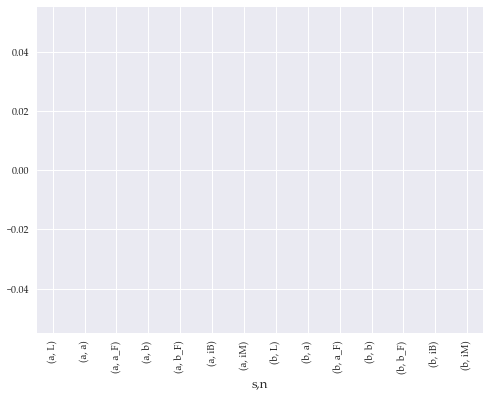

In [19]:
var= 'qD'
diagnostics.compare_data.std_diagnostics_var(db,GE_data,var)

### *Dynamic model:*

Next, we set up the dynamic model, building on the static solution, as well as the IO data. Specifically, we: (1) Initialize using nesting structure, (2) add specification of durables from IO data, (3) Initialize parameter values and initial guess of variables using static model, (4) run.

In [20]:
gm_p = Production.pr_dynamic(nt=nt,work_folder=work_folder,kwargs_st = {'sector':True, 'ss': GE_data.get('s_prod')}, gs_v=gs,**{'data_folder':gams_folder,'name':name_module}) # initialize model.
gm_p.add_dur(GE_data.get('dur'),dur2inv = GE_data.get('dur2inv')) # add specification of durables
gm_p.ivfs(db,merge=False) # initialzie levels from static model
gm_p.initialize_variables(**{'check_variables': True}) # give all variables without a initial level some (semi) random number.
gm_p.model.database[gm_p.n('mu')].vals = db.get(gm_p.n('mu')) # update values of mu-parameters to static solution

Finally, update the prices $PwT$ on investment goods that are not automatically loaded from the static version (where the investment behavior was not included):

In [21]:
gm_p.model.database[gm_p.n('PwT')] = DataBase_wheels.repeat_variable_windex(GE_data['PwT'].rctree_pd(GE_data['inv']),gs.get('txE')).combine_first(gm_p.get('PwT'))

To calibrate to IO data, we start by adding the baseline year to the IO data:

In [22]:
GE_prod_t = DataBase.GPM_database()
for var in GE_prod.variables_flat:
    GE_prod_t[var] = DataBase_wheels.repeat_variable_windex(GE_prod.get(var),gm_p.get('t0'))

We further adjust the capital depreciation rates to ensure the model is in a steady state. The depreciation rates are then fitted to data at a later point in the proces (see Example1_cont.ipynb):

In [23]:
gm_p.ss_rDepr(GE_data)

The calibration method we apply form a grid of values between the database in the model, and the target database (GE\_prod\_t in this case),  and asks GAMS to solve the model on this grid. However, this only works on exogenous variables. To make sure that this works we do the following:
1. Set the *state* of the model to calibration.
2. Subset the target database *GE\_prod\_t* to only include exogenous variables (all *gmspython* models can access the exogenous/endogenous variables by calling the *self.var_exo(symbol)* method).
3. Run the calibration function.

In [24]:
gm_p.setstate('DC')

*Subset variables to exogenous variables:*

In [25]:
GE_prod_t = gm_p.slice_exo(GE_prod_t,copy=False)

*Calibrate sneakily (target the database GE\_prod\_t, if files w. same names exists overwrite them, sneak up on the solution in n\_steps):*

In [26]:
gm_p.calibrate_sneaky(GE_prod_t,overwrite=True,**{'n_steps': 10,'diff':True})

{'Modelstat': 16.0, 'Solvestat': 1.0}

*Store as pickle to run from at a later point:*

In [27]:
db = gm_p.model_instances['baseline'].out_db 
[db.series.__delitem__(sym) for sym in db.symbols if sym not in gm_p.model.database.symbols]; # delete symbols that are created only in order to calibrate model.
gm_p.model.database.merge_dbs(gm_p.model.database,db,'second')
gm_p.export()

'C:\\Users\\sxj477\\Documents\\GitHub\\GPM_v05\\examples\\gamsmodels\\GE\\gmspython_p'

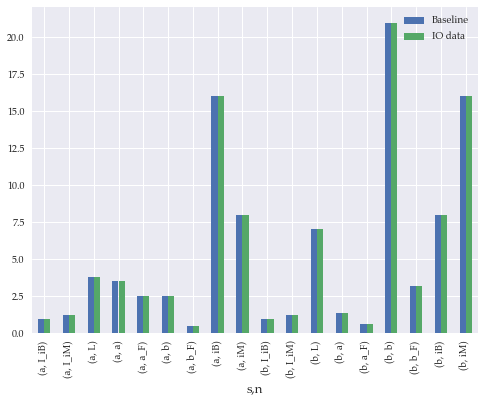

In [28]:
compare_vars,year = 'qD',2
ci = DataBase.gpy_symbol(db[compare_vars].rctree_pd(GE_prod[compare_vars]).xs(year))
pd.DataFrame({'Baseline': db[compare_vars].rctree_pd(ci).xs(year), 'IO data': GE_prod[compare_vars].rctree_pd(ci)}).plot.bar(figsize=(8,6));

## **3.2: The *Household.py* module**

*The household module is handled in more detail in the notebook 'Ex1\_household.ipynb'.*

Similarly to the production module, the household module is also initialized using nesting trees. The trees specify how the consumer derives utility from aggregating goods. The nesting trees used for the household are different, however, in a number of ways. For instance, whereas the 'most upper' nest of the production module always symbolizes outputs (supply), and the 'most lower' nest inputs (demand), there is no such restriction on the household nesting tree. 

The current module uses a CRRA intertemporal utility setup, that is only tied to the upper-most aggregate level of consumption in the nesting tree (this can easily be altered). Furthermore, we fix the labor supply (but can similarly easily be endogenized / included in the nesting tree). 

### *Required Data:*

The necessary data includes:
1. IO data on the sectors (already included).
2. Nesting structure of the utility function, including preference parameters (impatience, CES, CRRA).
3. An inventory of the assets/endowments of the household sector(s), as well as relevant tax rates (see tax module for more).

*Define settings for the module (simpler setup than production, as we only use one tree, i.e. no looping)*

In [29]:
name_module = 'HH' 
tree_name = 'HH_agg' 
file, sheet = 'HH.xlsx', 'nesting'

*Define partial equilibrium data, and general equilibrium data that are subsetted for the household sector:*

In [30]:
PE_data = ReadData.PE_from_GE(GE_data,GE_data.get('s_HH')[0])
GE_HH = small_updates.subset_db(GE_data.copy(),GE_data.get('s_HH'))

*read in nesting tree (similar to production, but a simpler setup):*

In [31]:
nt = nesting_tree.nesting_tree_hh(name=name_module,**{'version':'v1'}) # the version specifies calibration type.
nt.add_tree(data_folder+'\\'+file,tree_name=tree_name,**{'sheet':sheet}) # initialize tree
data = excel2py.xl2PM.pm_from_workbook(data_folder+'\\'+file,{sheet:'vars'})
DataBase.GPM_database.merge_dbs(nt.trees[tree_name].database, data ,'second') # add data
nt.run_all(PE_data,s0=GE_data.get('s_HH')[0],postfix='_'+name_module,int_temp = data['crra'].index) # add attributes

### *Static model:*

As in the production module, we start by setting up a static version of the model and calibrate this to the IO data. The steps are generally the same here as in the production module: (1) Initialize static model from nesting tree, (2) Add IO data to the model database, (3) solve and calibrate model.

*set up data and model:*

In [32]:
gm_static = Household.hh_static(nt=nt,work_folder=work_folder,**{'data_folder':work_folder,'name':'hh_static'})
DataBase.GPM_database.merge_dbs(gm_static.model.database,GE_HH,'second')

*slice IO data to only use exongeous data:*

In [33]:
gm_static.setstate('DC') # set state to 'dynamic calibration (DC), don't initialize settings
GE_HH_exo = gm_static.slice_exo(GE_HH,copy=True)

*calibrate (sneakily):*

In [34]:
gm_static.calibrate_sneaky(GE_HH_exo,kwargs_init={'check_variables':True},**{'n_steps':10})
db_static = gm_static.model_instances['baseline'].out_db

### *Dynamic model:*

The dynamic model is then based on the static one (as was the case w. the production module). Specifically we (1) initialize from the nesting tree, (2) add the savings subset, (3) initialize levels from the static model solution:

In [35]:
gm_hh = Household.hh_dynamic(nt=nt,work_folder=work_folder, gs_v = gs,**{'data_folder':gams_folder,'name':name_module})
gm_hh.add_svngs() # define subset of savings; call this element 'svngs' as default.
gm_hh.ivfs(db_static,merge=False) # initialize levels from static model
gm_hh.initialize_variables(**{'check_variables':True})
gm_hh.model.database[gm_hh.n('mu')].vals = db_static.get(gm_hh.n('mu')) # update calibrated parameters

Next, we add the baseline year to the IO data, slice the IO data to the values that are exogenous in the model and calibrate:

In [36]:
GE_HH_t = DataBase.GPM_database()
for var in GE_HH.variables_flat:
    GE_HH_t[var] = DataBase_wheels.repeat_variable_windex(GE_HH.get(var),gm_hh.get('t0'))
gm_hh.setstate('DC') # set state to 'dynamic calibration (DC)'
GE_HH_t = gm_hh.slice_exo(GE_HH_t,copy=False)
gm_hh.calibrate_sneaky(GE_HH_t,overwrite=True,**{'n_steps': 10,'diff':True})

{'Modelstat': 16.0, 'Solvestat': 1.0}

*Store as pickle to run from at a later point:*

In [37]:
db = gm_hh.model_instances['baseline'].out_db 
[db.series.__delitem__(sym) for sym in db.symbols if sym not in gm_hh.model.database.symbols]; # delete symbols that are created only in order to calibrate model.
gm_hh.model.database.merge_dbs(gm_hh.model.database,db,'second')
gm_hh.export()

'C:\\Users\\sxj477\\Documents\\GitHub\\GPM_v05\\examples\\gamsmodels\\GE\\gmspython_HH'

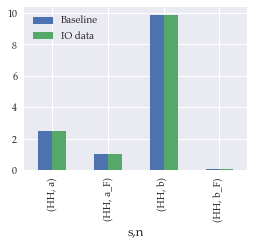

In [38]:
compare_vars,year = 'qD',2
ci = DataBase.gpy_symbol(db[compare_vars].rctree_pd(GE_HH[compare_vars]).xs(year))
pd.DataFrame({'Baseline': db[compare_vars].rctree_pd(ci).xs(year), 'IO data': GE_HH[compare_vars].rctree_pd(ci)}).plot.bar(figsize=(4,3));

## **3.3: The *investment.py* module**

*The investment module is handled in more detail in the notebook 'Ex1\_invest.ipynb'.*

The investment module essentially works as a production module (when static). The dynamic module is slightly different.

### *Required Data:*

*Define settings for the module:*

In [39]:
name_module = 'inv'
trees = {'I_B': {'file': 'inv_B.xlsx', 'sheets': ['nest']}, 
         'I_M': {'file': 'inv_M.xlsx', 'sheets': ['nest']}}
kwargs_st = {'sector': True, 'ss': GE_data.get('s_inv')} # settings for initializing the module
namespace = {k: name+'_'+k for k in ('inp','out','int','wT','map_all','kno_out','kno_inp','n_out','endo_PbT','exo_mu','PwT_dom')} # as the production module uses the same nesting tree, we adjust the standard names here

*Define tree:*

In [40]:
nts = {}
for s,t in trees.items():
    nts[s] = nesting_tree.nesting_tree(name=name_module) # initialize tree
    for tree in t['sheets']:
        nts[s].add_tree(data_folder+'\\'+t['file'],tree_name=tree,**{'sheet':tree}) # add nesting structure
        DataBase.GPM_database.merge_dbs(nts[s].trees[tree].database, excel2py.xl2PM.pm_from_workbook(data_folder+'\\'+t['file'],{tree:'vars'}),'second') # add data
    nts[s].run_all(s0=s,**namespace) # add default attributes from nesting structure
nesting_tree.merge_nts(list(nts.values())[0], list(nts.values())[1:]) # merge trees into one.
nt = list(nts.values())[0]

### *Static model:*

*similar to production module: initialize from nt, add IO data, calibrate.*

In [41]:
gm_static = Invest.pr_static(nt=nt,work_folder = work_folder,kwargs_ns=namespace,**{'data_folder':work_folder,'name':'I_static'})
GE_inv = small_updates.subset_db(GE_data.copy(),GE_data.get('s_inv'))
DataBase.GPM_database.merge_dbs(gm_static.model.database,GE_inv,'second')
gm_static.setstate('DC')
db_temp = gm_static.slice_exo(GE_inv,copy=True)
gm_static.calibrate_sneaky(db_temp,kwargs_init={'check_variables':True},**{'n_steps':100, 'gridtype': 'pol','phi':0.9})
db_static = gm_static.model_instances['baseline'].out_db

### *Dynamic model:*

Set up model and build on static setup/solution:

In [42]:
gm_inv = Invest.inv_dynamic(nt=nt,work_folder=work_folder,gs_v=gs,kwargs_st=kwargs_st,kwargs_ns=namespace,**{'data_folder':gams_folder,'name': name_module})
gm_inv.ivfs(db_static,merge=False)
gm_inv.initialize_variables(**{'check_variables':True})
gm_inv.model.database[gm_inv.n('mu')].vals = db_static.get(gm_inv.n('mu'))
gm_inv.model.database[gm_inv.n('markup')].vals = db_static.get(gm_inv.n('markup'))

The investment module does not need a dynamic calibration; thus we simply solve the model in baseline mode and store it:

In [43]:
gm_inv.setstate('DC')
gm_inv.setstate('B')
gm_inv.write_and_run(overwrite=True) # the overwrite=True option overwrites existing file with same names.

In [44]:
db = gm_inv.model_instances['baseline'].out_db 
[db.series.__delitem__(sym) for sym in db.symbols if sym not in gm_inv.model.database.symbols];
gm_inv.model.database.merge_dbs(gm_inv.model.database,db,'second')
gm_inv.export()

'C:\\Users\\sxj477\\Documents\\GitHub\\GPM_v05\\examples\\gamsmodels\\GE\\gmspython_inv'

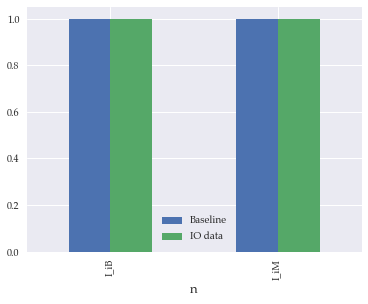

In [45]:
compare_vars,year = 'Peq',2
ci = DataBase.gpy_symbol(db[compare_vars].rctree_pd(GE_inv[compare_vars]).xs(year))
pd.DataFrame({'Baseline': db[compare_vars].rctree_pd(ci).xs(year), 'IO data': GE_inv[compare_vars].rctree_pd(ci)}).plot.bar(figsize=(6,4.5));

### *Inventory investments:*

The IO data can also include 'inventory investments'. In this example, we simply include a "demand" for inventory that tends to zero over time (in an AR(1) manner). The inclusion of inventory investments are thus primarily to match IO data; behavior is ad hoc.

In [46]:
GE_itory = small_updates.subset_db(GE_data.copy(),GE_data.get('s_itory'))
for var in GE_itory.variables_flat:
    GE_itory[var] = DataBase_wheels.repeat_variable_windex(GE_itory.get(var),gs.get('t0'))

In [47]:
name_module = 'itory'
gm_itory = Invest.itoryD(work_folder=work_folder,databases=[GE_itory],gs_v=gs,**{'data_folder':gams_folder,'name':name_module})
gm_itory.write_and_run(kwargs_init={'check_variables':True},overwrite=True)

Export as pickle:

In [48]:
db = gm_itory.model_instances['baseline'].out_db 
[db.series.__delitem__(sym) for sym in db.symbols if sym not in gm_itory.model.database.symbols];
gm_itory.model.database.merge_dbs(gm_itory.model.database,db,'second')
gm_itory.export()

'C:\\Users\\sxj477\\Documents\\GitHub\\GPM_v05\\examples\\gamsmodels\\GE\\gmspython_itory'

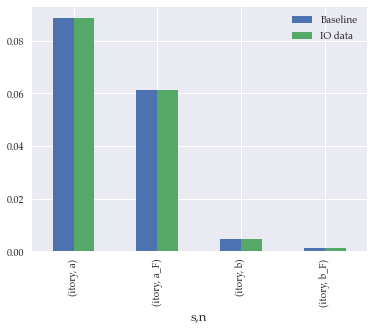

In [49]:
compare_vars,year = 'qD',1
ci = DataBase.gpy_symbol(db[compare_vars].rctree_pd(GE_data[compare_vars]).xs(year))
pd.DataFrame({'Baseline': db[compare_vars].rctree_pd(ci).xs(year), 'IO data': GE_data[compare_vars].rctree_pd(ci)}).plot.bar(figsize=(6,4.5));

## **3.4: The *Trade.py* module**

*The trade module is handled in more detail in the notebook 'Ex1\_trade.ipynb'.*

The trade model can be specified in various ways. In this simple module, the trade modules simply specifies the foreign demand for domestically produced goods in an Armington-like manner. As there are more than one foreign/domestic goods, the prices entering the demand function are the domestic price relative to the foreign price of a similar good; this similarity is declared in a mapping denoted *dom2for[n,nn]* coupling domestic goods to a foreign counterpart.

*Define settings for the module:*

In [50]:
name_module = 'trade'
data = {'file': 'trade.xlsx', 'sheets': {'vars': 'vars', 'dom2for': 'maps'}} # read in the sheet 'vars' as variables, and 'dom2for' as mappings.}
kwargs_st = {'sector': True, 'ss': GE_data.get('s_for')} # settings for initializing the module

*load data:*

In [51]:
db = excel2py.xl2PM.pm_from_workbook(data_folder+'\\'+data['file'],data['sheets'])

*initialize model:*

In [52]:
gm_trade = Trade.trade_dynamic(work_folder=work_folder,kwargs_st=kwargs_st,gs_v=gs,**{'data_folder':gams_folder,'name':name_module})

*subset GE data to relevant sectors:*

In [53]:
GE_trade = small_updates.subset_db(GE_data.copy(),GE_data.get('s_for'))

*initialize relevant subsets from GE data, and add data loaded from excel sheets:*

In [54]:
gm_trade.add_sets_from_GE(GE_trade)
DataBase.GPM_database.merge_dbs(gm_trade.model.database,db,'second')

*initialize variables from GE data:*

In [55]:
gm_trade.ivfs(GE_trade,merge=False) # initialize levels from static model

*set to calibration mode and solve:*

In [56]:
GE_trade_t = DataBase.GPM_database()
for var in GE_trade.variables_flat:
    GE_trade_t[var] = DataBase_wheels.repeat_variable_windex(GE_trade.get(var),gm_trade.get('t0'))
gm_trade.setstate('DC')
GE_trade_t = gm_trade.slice_exo(GE_trade_t,copy=False)
gm_trade.calibrate_sneaky(GE_trade_t,overwrite=True,**{'n_steps':2,'diff':True})

{'Modelstat': 15.0, 'Solvestat': 1.0}

*Export as pickle:*

In [57]:
db = gm_trade.model_instances['baseline'].out_db 
[db.series.__delitem__(sym) for sym in db.symbols if sym not in gm_trade.model.database.symbols];
gm_trade.model.database.merge_dbs(gm_trade.model.database,db,'second')
gm_trade.export()

'C:\\Users\\sxj477\\Documents\\GitHub\\GPM_v05\\examples\\gamsmodels\\GE\\gmspython_trade'

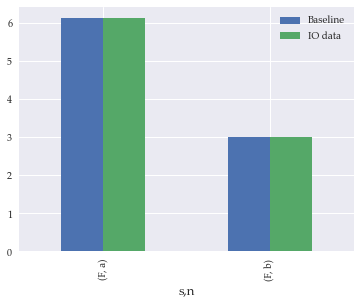

In [58]:
compare_vars,year = 'qD',2
ci = DataBase.gpy_symbol(db[compare_vars].rctree_pd(GE_data[compare_vars]).xs(year))
pd.DataFrame({'Baseline': db[compare_vars].rctree_pd(ci).xs(year), 'IO data': GE_data[compare_vars].rctree_pd(ci)}).plot.bar(figsize=(6,4.5));

## **3.5: The *Government.py* module**

The government sector defines the tax rates that goes into other modules. In the simplest case, we assume that taxation are in constant rates (from the perspective of the firms/consumers). This entails that three tax rates should be supplied by the government sector module:
* $tauD[t,s,n]$: The tax rate levied in the use of inputs such that $PwT[t,s,n] = Peq[t,n]+tauD[t,s,n]$ where $PwT$ is the price with taxes for sectors $s$, good $n$. The revenue from this tax is thus defined as $\sum_{(s,n)\in d\_tauD[s,n]} qD[t,s,n]*tauD[t,s,n]$.
* $tauS[t,s,n]$: The tax rate levied on the output of a sector. This defines the difference between prices before taxes and equilibrium taxes (some variations in how they are specifically used in modules). The revenue from this tax is defined as $\sum_{(s,n)\in d\_tauS[s,n]} qS[t,s,n] * tauS[t,s,n]$.
* $tauLump[t,s]$ for $s\in s\_HH$: The lump sum tax that is charged on households. For other sectors (production, investment), the lump-sum tax is computed as a part of the $tauS[t,s,n]$ tax on the sectors' outputs.

Note that this restricts us to only charge constant rates for supply/demand of any type, i.e. the marginal tax rate = average tax rate. However, nothing prevents us from creating more elaborate functions for how these prices may evolve (as functions e.g. of quantity variables). 

### *A simple setup for tax rates:*

In the following we define a simple government sector with the following instruments:
* $tauLump[t,s]$: A lump-sum tax is levied on all sectors except (1) trade and (2) inventory investment sectors.
* $tauS[t,s,n]$: A flat rate charged on the supply of goods.
* $tauD[t,s,n]$: A flat rate charged on the demand of goods.

### *Data requirements:*

Data on the specific tax rates are per default set to 0, unless otherwise specified. In this instance, we read the tax rates in the data section (from the file 'Tax.xlsx'), and added them to the IO data stored in *GE_data*. They were, however, only for the baseline year. In this instance, we assume these are kept constant (for now). Other versions of the government sector may include more elaborate tax rules, thus endogenizing the rates. This should be straightforward to provide.

*settings:*

In [59]:
name_module = 'G'

### *Static model:*

In [60]:
gm_static = Government.g_static(GE_data=GE_data.copy(),work_folder=work_folder,**{'data_folder':gams_folder,'name':'g_static'})

Run simple baseline model:

In [61]:
gm_static.write_and_run(kwargs_init={'check_variables':True},overwrite=True)

*Calibrate:*

In [62]:
gm_static.setstate('SC')
gm_static.reset_settings() # this resets the RunFile and CollectFile settings.
gm_static.write_and_run(overwrite=True) # this overwrites files in the work_folder if they already exists.
db_static = gm_static.model_instances['baseline'].out_db

### *Dynamic model:*

In [63]:
gm_G = Government.g_dynamic(GE_data=GE_data.copy(),work_folder=work_folder,gs_v=gs,**{'data_folder':gams_folder,'name':name_module})
gm_G.ivfs(db_static,merge=False)
gm_G.initialize_variables(**{'check_variables': True})

In [64]:
GE_G = small_updates.subset_db(GE_data.copy(),gm_G.get('s_G'))
GE_G_t = DataBase.GPM_database()
for var in GE_G.variables_flat:
    GE_G_t[var] = DataBase_wheels.repeat_variable_windex(GE_G.get(var),gm_G.get('t0'))
gm_G.setstate('DC')
GE_G_t = gm_G.slice_exo(GE_G_t,copy=False)
gm_G.calibrate_sneaky(GE_G_t,overwrite=True,**{'n_steps':2,'diff':True})

{'Modelstat': 15.0, 'Solvestat': 1.0}

*Store as pickle to run from at a later point:*

In [65]:
db = gm_G.model_instances['baseline'].out_db 
[db.series.__delitem__(sym) for sym in db.symbols if sym not in gm_G.model.database.symbols];
gm_G.model.database.merge_dbs(gm_G.model.database,db,'second')
gm_G.export()

'C:\\Users\\sxj477\\Documents\\GitHub\\GPM_v05\\examples\\gamsmodels\\GE\\gmspython_G'

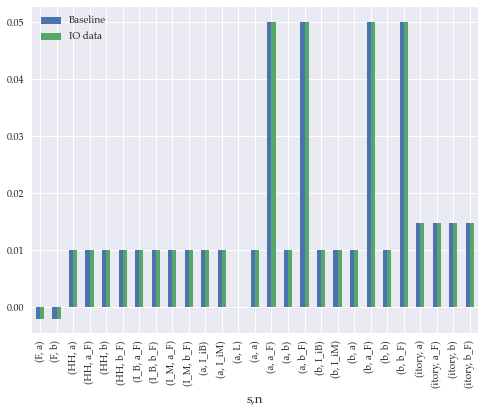

In [66]:
compare_vars,year = 'tauD',1
ci = DataBase.gpy_symbol(db[compare_vars].rctree_pd(GE_data[compare_vars]).xs(year))
pd.DataFrame({'Baseline': db[compare_vars].rctree_pd(ci).xs(year), 'IO data': GE_data[compare_vars].rctree_pd(ci)}).plot.bar(figsize=(8,6));